**Pytorch一般有以下几个流程**


### 1. 数据读取

### 2. 数据处理

### 3. 搭建网络

### 4. 模型训练

### 5. 模型上线

### 1. 数据读取
CIFAR-10 是由 Hinton 的学生 Alex Krizhevsky 和 Ilya Sutskever 整理的一个用于识别普适物体的小型数据集。一共包含 10 个类别的 RGB 彩色图 片：飞机（ arplane ）、汽车（ automobile ）、鸟类（ bird ）、猫（ cat ）、鹿（ deer ）、狗（ dog ）、蛙类（ frog ）、马（ horse ）、船（ ship ）和卡车（ truck ）。图片的尺寸为 32×32 ，数据集中一共有 50000 张训练圄片和 10000 张测试图片。 

与 MNIST 数据集中目比， CIFAR-10 具有以下不同点：

    • CIFAR-10 是 3 通道的彩色 RGB 图像，而 MNIST 是灰度图像。
    • CIFAR-10 的图片尺寸为 32×32， 而 MNIST 的图片尺寸为 28×28，比 MNIST 稍大。
    • 相比于手写字符， CIFAR-10 含有的是现实世界中真实的物体，不仅噪声很大，而且物体的比例、 特征都不尽相同，这为识别带来很大困难。

首先使用`torchvision`加载和归一化我们的训练数据和测试数据。

    a、`torchvision`这个东西，实现了常用的一些深度学习的相关的图像数据的加载功能，比如cifar10、Imagenet、Mnist等等的，保存在`torchvision.datasets`模块中。
    
    b、同时，也封装了一些处理数据的方法。保存在`torchvision.transforms`模块中
    
    c、还封装了一些模型和工具封装在相应模型中,比如`torchvision.models`当中就包含了AlexNet，VGG，ResNet，SqueezeNet等模型。

In [1]:
%cd /content
!rm -rf Pytorch-Image-Classification
!git clone https://github.com/Dreaming-future/Pytorch-Image-Classification.git
%cd Pytorch-Image-Classification/
!pip install -r requirements.txt
%cd CIFAR10_code/

/content
Cloning into 'Pytorch-Image-Classification'...
remote: Enumerating objects: 464, done.
remote: Counting objects: 100% (236/236), done.
remote: Compressing objects: 100% (156/156), done.
remote: Total 464 (delta 134), reused 171 (delta 76), pack-reused 228
Receiving objects: 100% (464/464), 844.43 MiB | 17.50 MiB/s, done.
Resolving deltas: 100% (210/210), done.
/content/Pytorch-Image-Classification
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/content/Pytorch-Image-Classification/CIFAR10_code


In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchsummary import summary
torch.__version__

'1.12.1+cu113'

**由于torchvision的datasets的输出是[0,1]的PILImage，所以我们先先归一化为[-1,1]的Tensor**

首先定义了一个变换transform，利用的是上面提到的transforms模块中的Compose( )把多个变换组合在一起，可以看到这里面组合了ToTensor和Normalize这两个变换

`transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))`前面的（0.5，0.5，0.5） 是 R G B 三个通道上的均值， 后面(0.5, 0.5, 0.5)是三个通道的标准差，注意通道顺序是 R G B ，用过opencv的同学应该知道openCV读出来的图像是 BRG顺序。这两个tuple数据是用来对RGB 图像做归一化的，如其名称 Normalize 所示这里都取0.5只是一个近似的操作，实际上其均值和方差并不是这么多，但是就这个示例而言 影响可不计。精确值是通过分别计算R,G,B三个通道的数据算出来的。


In [3]:
transform = transforms.Compose([
#     transforms.CenterCrop(224),
    transforms.RandomCrop(32,padding=4), # 数据增广
    transforms.RandomHorizontalFlip(),  # 数据增广
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
]) 

 `trainloader`其实是一个比较重要的东西，我们后面就是通过`trainloader`把数据传入网络，当然这里的`trainloader`其实是个变量名，可以随便取，重点是他是由后面的`torch.utils.data.DataLoader()`定义的，这个东西来源于`torch.utils.data`模块

In [4]:
Batch_Size = 64
transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

In [5]:
trainset = datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
testset = datasets.CIFAR10(root='./data',train=False,download=True,transform=transform_test)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=Batch_Size,shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=Batch_Size,shuffle=True, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### 2. 查看数据（格式，大小，形状）

In [6]:
classes = trainset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [7]:
trainset.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [8]:
trainset.data.shape #50000是图片数量，32x32是图片大小，3是通道数量RGB

(50000, 32, 32, 3)

In [9]:
#查看数据类型
print(type(trainset.data))
print(type(trainset))

<class 'numpy.ndarray'>
<class 'torchvision.datasets.cifar.CIFAR10'>


#### 总结：
    
    `trainset.data.shape`是标准的numpy.ndarray类型，其中50000是图片数量，32x32是图片大小，3是通道数量RGB；
    `trainset`是标准的？？类型，其中50000为图片数量，0表示取前面的数据，2表示3通道数RGB，32*32表示图片大小
    
 ### 3. 查看图片

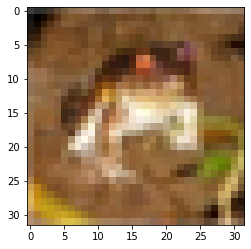

In [10]:
import numpy as np
import matplotlib.pyplot as plt
plt.imshow(trainset.data[0])
im,label = iter(trainloader).next()

#### np.ndarray转为torch.Tensor

在深度学习中，原始图像需要转换为深度学习框架自定义的数据格式，在pytorch中，需要转为`torch.Tensor`。
pytorch提供了`torch.Tensor` 与`numpy.ndarray`转换为接口：

方法名|作用
--|--
`torch.from_numpy(xxx)`|`numpy.ndarray`转为torch.Tensor
`tensor1.numpy()`|获取tensor1对象的numpy格式数据

`torch.Tensor` 高维矩阵的表示： N x C x H x W

`numpy.ndarray` 高维矩阵的表示：N x H x W x C

因此在两者转换的时候需要使用`numpy.transpose( )` 方法 。


In [11]:
def imshow(img):
    img = img / 2 + 0.5
    img = np.transpose(img.numpy(),(1,2,0))
    plt.imshow(img)

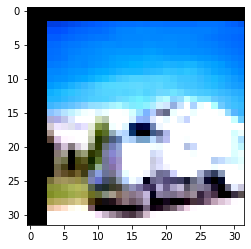

In [12]:
imshow(im[0])

In [13]:
im[0].shape

torch.Size([3, 32, 32])

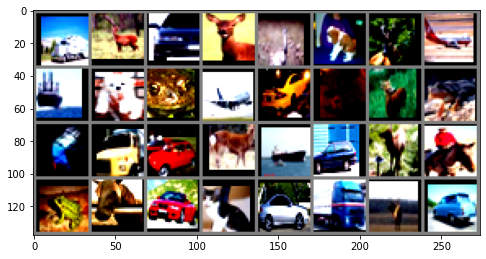

In [14]:
plt.figure(figsize=(8,12))
imshow(torchvision.utils.make_grid(im[:32]))

## 4. 定义网络（ViT篇）

### Vision Transformer（ViT）简介

近些年，随着基于自注意（Self-Attention）结构的模型的发展，特别是Transformer模型的提出，极大地促进了自然语言处理模型的发展。由于Transformers的计算效率和可扩展性，它已经能够训练具有超过100B参数的空前规模的模型。

ViT则是自然语言处理和计算机视觉两个领域的融合结晶。在不依赖卷积操作的情况下，依然可以在图像分类任务上达到很好的效果。

**模型结构**

ViT模型的主体结构是基于Transformer模型的Encoder部分（部分结构顺序有调整，如：Normalization的位置与标准Transformer不同），其结构图[1]如下：

![vit-architecture](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/tutorials/application/source_zh_cn/cv/images/vit_architecture.png)

**模型特点**

ViT模型主要应用于图像分类领域。因此，其模型结构相较于传统的Transformer有以下几个特点：

1. 数据集的原图像被划分为多个patch后，将二维patch（不考虑channel）转换为一维向量，再加上类别向量与位置向量作为模型输入。
2. 模型主体的Block结构是基于Transformer的Encoder结构，但是调整了Normalization的位置，其中，最主要的结构依然是Multi-head Attention结构。
3. 模型在Blocks堆叠后接全连接层，接受类别向量的输出作为输入并用于分类。通常情况下，我们将最后的全连接层称为Head，Transformer Encoder部分为backbone。

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' # 判断是否用GPU
device

'cuda'

### Transformer基本原理

Transformer模型源于2017年的一篇文章[2]。在这篇文章中提出的基于Attention机制的编码器-解码器型结构在自然语言处理领域获得了巨大的成功。模型结构如下图所示：

![transformer-architecture](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/tutorials/application/source_zh_cn/cv/images/transformer_architecture.png)

其主要结构为多个Encoder和Decoder模块所组成，其中Encoder和Decoder的详细结构如下图[2]所示：

![encoder-decoder](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/tutorials/application/source_zh_cn/cv/images/encoder_decoder.png)

Encoder与Decoder由许多结构组成，如：多头注意力（Multi-Head Attention）层，Feed Forward层，Normaliztion层，甚至残差连接（Residual Connection，图中的“Add”）。不过，其中最重要的结构是多头注意力（Multi-Head Attention）结构，该结构基于自注意力（Self-Attention）机制，是多个Self-Attention的并行组成。

所以，理解了Self-Attention就抓住了Transformer的核心。

### Attention模块

以下是Self-Attention的解释，其核心内容是为输入向量的每个单词学习一个权重。通过给定一个任务相关的查询向量Query向量，计算Query和各个 Key的相似性或者相关性得到注意力分布，即得到每个Key对应Value的权重系数，然后对Value进行加权求和得到最终的Attention数值。

在Self-Attention中:

1. 最初的输入向量首先会经过Embedding层映射成Q (Query)， $K$ (Key)，V (Value) 三个向量，由于是并行操作，所以代码中是映射成为dim $x$ 3 的向量然后进行分割，换言之，如果你的输入向量为一个向量序列 $\left(x_1 ， x_2 ， x_3\right)$ ，其中的 $x_1 ， x_2 ， x_3$ 都是一维向量，那么每一个一维向量 都会经过Embedding层映射出Q，K，V三个向量，只是Embedding矩阵不同，矩阵参数也是通过学习得到的。**这里大家可以认为， $Q ， K ， V$ 三个 矩阵是发现向量之间关联信息的一种手段，需要经过学习得到，至于为什么是 $Q ， K ， V$ 三个，主要是因为需要两个向量点乘以获得权重，又需要 另一个向量来承载权重向加的结果，所以，最少需要 3 个矩阵。**
   $$
   \left\{\begin{array}{l}q_i=W_q \cdot x_i \\k_i=W_k \cdot x_i, \quad i=1,2,3 \ldots \\v_i=W_v \cdot x_i\end{array}\right.
   $$
   ![self-attention1](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/tutorials/application/source_zh_cn/cv/images/self_attention_1.png)

2. 自注意力机制的自注意主要体现在它的Q，K，V都来源于其自身，也就是该过程是在提取输入的不同顺序的向量的联系与特征，最终通过不同顺序向量之间的联系紧密性（Q与K乘积经过Softmax的结果）来表现出来。**Q，K，V得到后就需要获取向量间权重，需要对Q和K进行点乘并除以维度的平方根，对所有向量的结果进行Softmax处理，通过公式(2)的操作，我们获得了向量之间的关系权重。**
   $$
   \begin{split}\begin{cases}
   a_{1,1} = q_1 \cdot k_1 / \sqrt d \\
   a_{1,2} = q_1 \cdot k_2 / \sqrt d \\
   a_{1,3} = q_1 \cdot k_3 / \sqrt d
   \end{cases}
   \end{split}
   $$
   ![self-attention3](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/tutorials/application/source_zh_cn/cv/images/self_attention_3.png)
   $$
   Softmax: \hat a_{1,i} = exp(a_{1,i}) / \sum_j exp(a_{1,j}),\hspace{1em} j = 1,2,3 \ldots \tag{3}
   $$
   ![self-attention2](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/tutorials/application/source_zh_cn/cv/images/self_attention_2.png)

3. 其最终输出则是通过V这个映射后的向量与Q，K经过Softmax结果进行weight sum获得，这个过程可以理解为在全局上进行自注意表示。**每一组Q，K，V最后都有一个V输出，这是Self-Attention得到的最终结果，是当前向量在结合了它与其他向量关联权重后得到的结果。**
   $$
   b_1 = \sum_i \hat a_{1,i}v_i,\hspace{1em} i = 1,2,3...
   \tag{4}
   $$
   通过下图可以整体把握Self-Attention的全部过程。

   ![self-attention](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/tutorials/application/source_zh_cn/cv/images/self_attention_process.png)

   多头注意力机制就是将原本self-Attention处理的向量分割为多个Head进行处理，这一点也可以从代码中体现，这也是attention结构可以进行并行加速的一个方面。

   总结来说，多头注意力机制在保持参数总量不变的情况下，将同样的query, key和value映射到原来的高维空间（Q,K,V）的不同子空间$(Q_0,K_0,V_0)$中进行自注意力的计算，最后再合并不同子空间中的注意力信息。

   所以，对于同一个输入向量，多个注意力机制可以同时对其进行处理，即利用并行计算加速处理过程，又在处理的时候更充分的分析和利用了向量特征。下图展示了多头注意力机制，其并行能力的主要体现在下图中的a1和a2是同一个向量进行分割获得的。

   ![multi-head-attention](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/tutorials/application/source_zh_cn/cv/images/multi_head_attention.png)

In [16]:

class Attention(nn.Module):
    '''
    Attention Module used to perform self-attention operation allowing the model to attend
    information from different representation subspaces on an input sequence of embeddings.
    The sequence of operations is as follows :-

    Input -> Query, Key, Value -> ReshapeHeads -> Query.TransposedKey -> Softmax -> Dropout
    -> AttentionScores.Value -> ReshapeHeadsBack -> Output
    '''
    def __init__(self, 
                 embed_dim, # 输入token的dim
                 heads=8, 
                 activation=None, 
                 attn_drop_ratio=0.,
                 proj_drop_ratio=0.):
        super().__init__()
        self.heads = heads
        self.embed_dim = embed_dim
        head_dim = embed_dim // heads  # 每一个head的dim数
        self.scale = head_dim ** -0.5 # ViT-B 就是 768//12 = 64 
        
        # 这里的q,k,v 可以用三个Linear层
        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        
        # 或者一个Linear层，但是out_channel为三倍，并行的思想
        self.qkv = nn.Linear(embed_dim, embed_dim*3)
        
        # self.softmax = nn.Softmax(dim = -1) # 对每一行进行softmax
        
        if activation == 'relu':
            self.activation = nn.ReLU()
        else:
            self.activation = nn.Identity()
        self.attn_drop = nn.Dropout(attn_drop_ratio)
        # Multi-head的拼接，需要一个参数Wo，靠此层进行训练
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.proj_drop = nn.Dropout(proj_drop_ratio)
        
    def forward(self, x):
        # [batch_size, num_patches + 1, total_embed_dim]
        # [batch_size, seq_len        , total_embed_dim]
        B, N, C = x.shape
        assert C == self.embed_dim
        
        # 1. qkv -> [batch_size, num_patches + 1, 3 * total_embed_dim]
        qkv = self.qkv(x).reshape(B, N, 3, self.heads, C//self.heads).permute(2, 0, 3, 1, 4)
        # reshape: -> [batch_size, num_patches + 1, 3, num_heads, embed_dim_per_head]
        # permute: -> [3, batch_size, num_heads, num_patches + 1, embed_dim_per_head]
        # # [batch_size, num_heads, num_patches + 1, embed_dim_per_head]
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        # transpose: -> [batch_size, num_heads, embed_dim_per_head, num_patches + 1]
        # @: multiply -> [batch_size, num_heads, num_patches + 1, num_patches + 1]
        attn = (q @ k.transpose(-2,-1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        #  # @: multiply -> [batch_size, num_heads, num_patches + 1, embed_dim_per_head]
        # transpose: -> [batch_size, num_patches + 1, num_heads, embed_dim_per_head]
        # reshape: -> [batch_size, num_patches + 1, total_embed_dim]
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


### MLP多层感知机（MLP）

Transformer 结构中还有一个重要的结构就是 MLP，即多层感知机，如 **图**所示。

![图6 MLP多层感知机的结构](https://paddlepedia.readthedocs.io/en/latest/_images/VIT_pic6.png)

多层感知机由输入层、输出层和至少一层的隐藏层构成。网络中各个隐藏层中神经元可接收相邻前序隐藏层中所有神经元传递而来的信息，经过加工处理后将信息输出给相邻后续隐藏层中所有神经元。在多层感知机中，相邻层所包含的神经元之间通常使用“全连接”方式进行连接。多层感知机可以模拟复杂非线性函数功能，所模拟函数的复杂性取决于网络隐藏层数目和各层中神经元数目。多层感知机的结构如 **图** 所示。

![图7 多层感知机](https://paddlepedia.readthedocs.io/en/latest/_images/MLP.png)

In [17]:
class Mlp(nn.Module):
    '''
    MLP as used in Vision Transformer
    
    Input -> FC1 -> GELU -> Dropout -> FC2 -> Output
    '''
    def __init__(self,
                 in_features,
                 hidden_features = None,
                 out_features = None,
                 act_layer = nn.GELU, # 激活函数
                 drop = 0.
                 ):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

### Transformer Encoder

在了解了Self-Attention结构之后，通过与Feed Forward，Residual Connection等结构的拼接就可以形成Transformer的基础结构，接下来就利用Self-Attention来构建ViT模型中的TransformerEncoder部分，类似于构建了一个Transformer的编码器部分，如下图[1]所示：

![vit-encoder](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/tutorials/application/source_zh_cn/cv/images/vit_encoder.png)

1. ViT模型中的基础结构与标准Transformer有所不同，主要在于Normalization的位置是放在Self-Attention和Feed Forward之前，其他结构如Residual Connection，Feed Forward，Normalization都如Transformer中所设计。
2. 从Transformer结构的图片可以发现，多个子encoder的堆叠就完成了模型编码器的构建，在ViT模型中，依然沿用这个思路，通过配置超参数num_layers，就可以确定堆叠层数。
3. Residual Connection，Normalization的结构可以保证模型有很强的扩展性（保证信息经过深层处理不会出现退化的现象，这是Residual Connection的作用），Normalization和dropout的应用可以增强模型泛化能力。



在ViT的实现中，由于drop_path的效果似乎比dropout好，所以这里换成了drop Path，不过也可以drop out。

In [18]:
def drop_path(x, drop_prob: float = 0., training: bool = False):
    """
    Drop paths (Stochastic Depth) per sample (when applied in main path of residual blocks).
    This is the same as the DropConnect impl I created for EfficientNet, etc networks, however,
    the original name is misleading as 'Drop Connect' is a different form of dropout in a separate paper...
    See discussion: https://github.com/tensorflow/tpu/issues/494#issuecomment-532968956 ... I've opted for
    changing the layer and argument names to 'drop path' rather than mix DropConnect as a layer name and use
    'survival rate' as the argument.
    """
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    output = x.div(keep_prob) * random_tensor
    return output


class DropPath(nn.Module):
    """
    Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).
    """
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)

In [19]:

class TransformerBlock(nn.Module):
    '''
    Transformer Block combines both the attention module and the feed forward module with layer
    normalization, dropout and residual connections. The sequence of operations is as follows :-
    
    Input -> LayerNorm1 -> Attention -> Residual -> LayerNorm2 -> FeedForward -> Output
      |                                   |  |                                      |
      |-------------Addition--------------|  |---------------Addition---------------|
    '''
    
    def __init__(self, 
                 embed_dim, 
                 heads=8,
                 mlp_ratio=4, # mlp为4倍
                 drop_ratio=0.,
                 attn_drop_ratio=0.,
                 drop_path_ratio=0.,
                 activation=nn.GELU,
                 norm_layer = nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(embed_dim)
        self.attn = Attention(embed_dim, heads=heads, 
                              attn_drop_ratio=attn_drop_ratio, proj_drop_ratio=drop_ratio)
        
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        # 这里可以选择 drop path， 或者Drop out， 在官方代码中使用了Drop path
        self.drop_path = DropPath(drop_path_ratio)
        # self.drop = nn.Dropout(drop_path_ratio)
        self.norm2 = norm_layer(embed_dim)
        mlp_hidden_dim = int(embed_dim * mlp_ratio)
        self.mlp = Mlp(in_features=embed_dim, hidden_features=mlp_hidden_dim, act_layer=activation, drop=drop_ratio)
    
    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x


### ViT模型的输入

传统的Transformer结构主要用于处理自然语言领域的词向量（Word Embedding or Word Vector），词向量与传统图像数据的主要区别在于，词向量通常是1维向量进行堆叠，而图片则是二维矩阵的堆叠，多头注意力机制在处理1维词向量的堆叠时会提取词向量之间的联系也就是上下文语义，这使得Transformer在自然语言处理领域非常好用，而2维图片矩阵如何与1维词向量进行转化就成为了Transformer进军图像处理领域的一个小门槛。

在ViT模型中：

1. 通过将输入图像在每个channel上划分为16*16个patch，这一步是通过卷积操作来完成的，当然也可以人工进行划分，但卷积操作也可以达到目的同时还可以进行一次而外的数据处理；**例如一幅输入224 x 224的图像，首先经过卷积处理得到16 x 16个patch，那么每一个patch的大小就是14 x 14。**
2. 再将每一个patch的矩阵拉伸成为一个1维向量，从而获得了近似词向量堆叠的效果。**上一步得到的14 x 14的patch就转换为长度为196的向量。**

In [20]:
class PatchEmbed(nn.Module):
    """
    2D Image to Patch Embedding
    """
    def __init__(self, img_size=224, patch_size=16, in_c=3, embed_dim=768, norm_layer=None):
        super().__init__()
        # 原始大小为int，转为tuple，即：img_size原始输入224，变换后为[224,224]
        img_size = (img_size, img_size)
        patch_size = (patch_size, patch_size) # 16 x 16
        self.img_size = img_size # 224 x 224
        self.patch_size = patch_size # 16 x 16
        self.grid_size = (img_size[0] // patch_size[0], img_size[1] // patch_size[1])  # 224/16 x 224/16 = 14 x 14
        self.num_patches = self.grid_size[0] * self.grid_size[1] # 14 x 14
        # kernel_size=块大小，即每个块输出一个值，类似每个块展平后使用相同的全连接层进行处理
        # 输入维度为3，输出维度为块向量长度
        # 与原文中：分块、展平、全连接降维保持一致
        # 输出为[B, C, H, W]
        self.proj = nn.Conv2d(in_c, embed_dim, kernel_size=self.patch_size, stride=self.patch_size) # 进行 patchty 化
        self.norm = norm_layer(embed_dim) if norm_layer else nn.Identity()
        
    def forward(self, x):
        B, C, H, W = x.shape
        assert H == self.img_size[0] and W == self.img_size[1], \
            "Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        # [B, C, H, W] -> [B, C, H*W] ->[B, H*W, C]
        # flatten: [B, C, H, W] -> [B, C, HW]
        # transpose: [B, C, HW] -> [B, HW, C]
        x = self.proj(x).flatten(2).transpose(1, 2)
        x = self.norm(x)
        return x

输入图像在划分为patch之后，会经过pos_embedding 和 class_embedding两个过程。

1. class_embedding主要借鉴了BERT模型的用于文本分类时的思想，在每一个word vector之前增加一个类别值，通常是加在向量的第一位，**上一步得到的196维的向量加上class_embedding后变为197维。**
2. 增加的class_embedding是一个可以学习的参数，经过网络的不断训练，最终以输出向量的第一个维度的输出来决定最后的输出类别；**由于输入是16 x 16个patch，所以输出进行分类时是取 16 x 16个class_embedding进行分类。**
3. pos_embedding也是一组可以学习的参数，会被加入到经过处理的patch矩阵中。
4. 由于pos_embedding也是可以学习的参数，所以它的加入类似于全链接网络和卷积的bias。**这一步就是创造一个长度维197的可训练向量加入到经过class_embedding的向量中。**

实际上，pos_embedding总共有4种方案。但是经过作者的论证，只有加上pos_embedding和不加pos_embedding有明显影响，至于pos_embedding是1维还是2维对分类结果影响不大，所以，在我们的代码中，也是采用了1维的pos_embedding，由于class_embedding是加在pos_embedding之前，所以pos_embedding的维度会比patch拉伸后的维度加1。

总的而言，ViT模型还是利用了Transformer模型在处理上下文语义时的优势，将图像转换为一种“变种词向量”然后进行处理，而这样转换的意义在于，多个patch之间本身具有空间联系，这类似于一种“空间语义”，从而获得了比较好的处理效果。

### 整体构建ViT



In [21]:
from functools import partial   
class VisionTransformer(nn.Module):
    '''
    Vision Transformer is the complete end to end model architecture which combines all the above modules
    in a sequential manner. The sequence of the operations is as follows -

    Input -> CreatePatches -> ClassToken, PatchToEmbed , PositionEmbed -> Transformer -> ClassificationHead -> Output
                                   |            | |                |
                                   |---Concat---| |----Addition----|
    '''
    def __init__(self,
                 img_size=224,
                 patch_size=16,
                 in_c=3,
                 num_classes=1000,
                 embed_dim=768,
                 depth=12,
                 heads=12,
                 mlp_ratio=4.0,
                 drop_ratio=0.,
                 attn_drop_ratio=0., 
                 drop_path_ratio=0., 
                 embed_layer=PatchEmbed, 
                 norm_layer=None,
                 act_layer=None):
        super().__init__()
        self.name = 'VisionTransformer'
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models
        self.num_tokens =1
        norm_layer = norm_layer or partial(nn.LayerNorm, eps=1e-6)
        act_layer = act_layer or nn.GELU
        
        self.patch_embed = embed_layer(img_size=img_size, patch_size=patch_size, in_c=in_c, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches

        # 位置编码 (1,embedim)
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + self.num_tokens, embed_dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim)) # 加上类别
        self.pos_drop = nn.Dropout(p=drop_ratio)

        # 等差数列的drop_path_ratio
        dpr = [x.item() for x in torch.linspace(0, drop_path_ratio, depth)]  # stochastic depth decay rule
        self.blocks = nn.Sequential(*[
            TransformerBlock(embed_dim=embed_dim, heads=heads, mlp_ratio=mlp_ratio,
                  drop_ratio=drop_ratio, attn_drop_ratio=attn_drop_ratio, drop_path_ratio=dpr[i],
                  norm_layer=norm_layer, activation=act_layer)
            for i in range(depth)
        ])
        self.norm = norm_layer(embed_dim)
        self.pre_logits = nn.Identity()
        # Classifier head(s)
        self.head = nn.Linear(self.num_features, num_classes) if num_classes > 0 else nn.Identity()
        
    
    def forward_features(self, x):
        # [B, C, H, W] -> [B, num_patches, embed_dim]
        x = self.patch_embed(x)  # [B, 196, 768]
        # [1, 1, 768] -> [B, 1, 768]
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)
        
        x = torch.cat((cls_token, x), dim=1)  # [B, 197, 768]
        x = self.pos_drop(x + self.pos_embed)
        x = self.blocks(x)
        # x (batch_size, seq_len+1, embed_dim) 
        
        x = self.norm(x)
        return self.pre_logits(x[:, 0]) # batch_size, embed_dim)
    
    def forward(self, x):
        x = self.forward_features(x)
        # (batch_size, embed_dim)
        x = self.head(x)
        # (batch_size, classes)
        
        return x
    
    def _init_vit_weights(m):
        """
        ViT weight initialization
        :param m: module
        """
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=.01)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode="fan_out")
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.LayerNorm):
            nn.init.zeros_(m.bias)
            nn.init.ones_(m.weight)


整体流程图如下所示：

![data-process](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/tutorials/application/source_zh_cn/cv/images/data_process.png)



**最后定义模型**

In [22]:
def vit_base_patch16_224(num_classes: int = 1000):
    model = VisionTransformer(img_size=224,
                              patch_size=16,
                              embed_dim=768,
                              depth=12,
                              heads=12,
                              num_classes=num_classes)
    return model




def vit_base_patch32_224(num_classes: int = 1000):
    model = VisionTransformer(img_size=224,
                              patch_size=32,
                              embed_dim=768,
                              depth=12,
                              heads=12,
                              num_classes=num_classes)
    return model



def vit_large_patch16_224(num_classes: int = 1000):
    model = VisionTransformer(img_size=224,
                              patch_size=16,
                              embed_dim=1024,
                              depth=24,
                              heads=16,
                              num_classes=num_classes)
    return model



def vit_large_patch32_224(num_classes: int = 21843):
    model = VisionTransformer(img_size=224,
                              patch_size=32,
                              embed_dim=1024,
                              depth=24,
                              heads=16,
                              num_classes=num_classes)
    return model


def vit_huge_patch14_224(num_classes: int = 21843):
 
    model = VisionTransformer(img_size=224,
                              patch_size=14,
                              embed_dim=1280,
                              depth=32,
                              heads=16,
                              num_classes=num_classes)
    return model


def vit_cifar_patch4_32(num_classes: int = 10):
    model = VisionTransformer(img_size=32,
                              num_classes = num_classes,
                              patch_size=2,
                              embed_dim=512,
                              depth=12,
                              heads=16)
    return model

In [23]:
!pip install torchinfo
from torchinfo import summary
net = vit_cifar_patch4_32()
summary(net,(1,3,32,32))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Layer (type:depth-idx)                   Output Shape              Param #
VisionTransformer                        [1, 10]                   132,096
├─PatchEmbed: 1-1                        [1, 256, 512]             --
│    └─Conv2d: 2-1                       [1, 512, 16, 16]          6,656
│    └─Identity: 2-2                     [1, 256, 512]             --
├─Dropout: 1-2                           [1, 257, 512]             --
├─Sequential: 1-3                        [1, 257, 512]             --
│    └─TransformerBlock: 2-3             [1, 257, 512]             --
│    │    └─LayerNorm: 3-1               [1, 257, 512]             1,024
│    │    └─Attention: 3-2               [1, 257, 512]             1,838,592
│    │    └─DropPath: 3-3                [1, 257, 512]             --
│    │    └─LayerNorm: 3-4               [1, 257, 512]             1,024
│    │    └─Mlp: 3-5                     [1, 257, 512]             2,099,712
│    │    └─DropPath: 3-6                [1, 257, 512]   

In [24]:
print(net)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 512, kernel_size=(2, 2), stride=(2, 2))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): TransformerBlock(
      (norm1): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (query): Linear(in_features=512, out_features=512, bias=True)
        (key): Linear(in_features=512, out_features=512, bias=True)
        (value): Linear(in_features=512, out_features=512, bias=True)
        (qkv): Linear(in_features=512, out_features=1536, bias=True)
        (activation): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=512, out_features=512, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): DropPath()
      (norm2): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=512, out_features=2048, bias=True)

In [25]:
# 测试
x = torch.randn(2, 3, 32, 32).to(device)
y = net(x)
print(y.shape)

torch.Size([2, 10])


In [26]:
net = vit_cifar_patch4_32().to(device)
if device == 'cuda':
    net = nn.DataParallel(net)
    # 当计算图不会改变的时候（每次输入形状相同，模型不改变）的情况下可以提高性能，反之则降低性能
    torch.backends.cudnn.benchmark = True

## 5. 定义损失函数和优化器

pytorch将深度学习中常用的优化方法全部封装在torch.optim之中，所有的优化方法都是继承基类optim.Optimizier
损失函数是封装在神经网络工具箱nn中的,包含很多损失函数

这里我使用的是SGD + momentum算法，并且我们损失函数定义为交叉熵函数，除此之外学习策略定义为动态更新学习率，如果5次迭代后，训练的损失并没有下降，那么我们便会更改学习率，会变为原来的0.5倍，最小降低到0.00001

如果想更加了解优化器和学习率策略的话，可以参考以下资料

- [Pytorch Note15 优化算法1 梯度下降（Gradient descent varients）](https://blog.csdn.net/weixin_45508265/article/details/117859824)
- [Pytorch Note16 优化算法2 动量法(Momentum)](https://blog.csdn.net/weixin_45508265/article/details/117874046)
- [Pytorch Note34 学习率衰减](https://blog.csdn.net/weixin_45508265/article/details/119089705)

这里决定迭代20次

In [27]:
import torch.optim as optim
# optimizer = optim.SGD(net.parameters(), lr=1e-1, momentum=0.9, weight_decay=5e-4)
optimizer = optim.Adam(net.parameters())
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.94,verbose=True,patience = 1,min_lr = 0.000001) # 动态更新学习率
# scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[150, 225], gamma=0.5)

import time
epoch = 20

## 6. 模型训练

In [28]:
import os
if not os.path.exists('./model'):
    os.makedirs('./model')
else:
    print('文件已存在')
save_path = './model/vit_cifar.pth'

文件已存在


In [ ]:
from utils import train
from utils import plot_history
Acc, Loss, Lr = train(net, trainloader, testloader, epoch, optimizer, criterion, scheduler, save_path, verbose = True)

 train   1| 20 69 %  [**********************************->................] 

In [ ]:
plot_history(epoch ,Acc, Loss, Lr)

## 7. 测试

In [ ]:
correct = 0   # 定义预测正确的图片数，初始化为0
total = 0     # 总共参与测试的图片数，也初始化为0
# testloader = torch.utils.data.DataLoader(testset, batch_size=32,shuffle=True, num_workers=2)
torch.cuda.empty_cache()
net.eval()
with torch.no_grad():
    for data in testloader:  # 循环每一个batch
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        net.eval()  # 把模型转为test模式
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = net(images)  # 输入网络进行测试

        # outputs.data是一个4x10张量，将每一行的最大的那一列的值和序号各自组成一个一维张量返回，第一个是值的张量，第二个是序号的张量。
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)          # 更新测试图片的数量
        correct += (predicted == labels).sum() # 更新正确分类的图片的数量

    print('Accuracy of the network on the 10000 test images: %.2f %%' % (100 * correct / total))

In [ ]:
 # 定义2个存储每类中测试正确的个数的 列表，初始化为0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
# testloader = torch.utils.data.DataLoader(testset, batch_size=64,shuffle=True, num_workers=2)
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = net(images)

        _, predicted = torch.max(outputs.data, 1)
    #4组(batch_size)数据中，输出于label相同的，标记为1，否则为0
        c = (predicted == labels).squeeze()
        for i in range(len(images)):      # 因为每个batch都有4张图片，所以还需要一个4的小循环
            label = labels[i]   # 对各个类的进行各自累加
            class_correct[label] += c[i]
            class_total[label] += 1
 
 
for i in range(10):
    print('Accuracy of %5s : %.2f %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images_ = images
#images_ = images_.view(images.shape[0], -1)
images_ = images_.to(device)
labels = labels.to(device)
val_output = net(images_)
_, val_preds = torch.max(val_output, 1)

fig = plt.figure(figsize=(25,4))

correct = torch.sum(val_preds == labels.data).item()

# val_preds = val_preds.cpu()
# labels = labels.cpu()

print("Accuracy Rate = {}%".format(correct/len(images) * 100))

fig = plt.figure(figsize=(25,25))
for idx in np.arange(64):    
    ax = fig.add_subplot(8, 8, idx+1, xticks=[], yticks=[])
    #fig.tight_layout()
#     plt.imshow(im_convert(images[idx]))
    imshow(images[idx])
    ax.set_title("{}, ({})".format(classes[val_preds[idx].item()], classes[labels[idx].item()]), 
                 color = ("green" if val_preds[idx].item()==labels[idx].item() else "red"))

## 8. 保存模型

In [ ]:
torch.save(net,save_path[:-4]+'_'+str(epoch)+'.pth')


## 9. 预测

In [ ]:
import torch
from PIL import Image
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
 
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ResNet50() # 这里需要根据所使用的模型进行加载

model = torch.load(save_path)  # 加载模型
# model = model.to('cuda')
model.eval()  # 把模型转为test模式

# 读取要预测的图片
img = Image.open("./airplane.jpg").convert('RGB') # 读取图像

In [ ]:
img

In [ ]:
trans = transforms.Compose([transforms.Scale((32,32)),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=(0.5, 0.5, 0.5), 
                                                 std=(0.5, 0.5, 0.5)),
                           ])
 
img = trans(img)
img = img.to(device)
# 图片扩展多一维,因为输入到保存的模型中是4维的[batch_size,通道,长，宽]，而普通图片只有三维，[通道,长，宽]
img = img.unsqueeze(0)  
    # 扩展后，为[1，1，28，28]
output = model(img)
prob = F.softmax(output,dim=1) #prob是10个分类的概率
print("概率",prob)
value, predicted = torch.max(output.data, 1)
print("类别",predicted.item())
print(value)
pred_class = classes[predicted.item()]
print("分类",pred_class)

In [ ]:
import requests
from PIL import Image
url = 'https://dss2.bdstatic.com/70cFvnSh_Q1YnxGkpoWK1HF6hhy/it/u=947072664,3925280208&fm=26&gp=0.jpg'
url = 'https://ss0.bdstatic.com/70cFuHSh_Q1YnxGkpoWK1HF6hhy/it/u=2952045457,215279295&fm=26&gp=0.jpg'
url = 'https://ss0.bdstatic.com/70cFvHSh_Q1YnxGkpoWK1HF6hhy/it/u=2838383012,1815030248&fm=26&gp=0.jpg'
url = 'https://gimg2.baidu.com/image_search/src=http%3A%2F%2Fwww.goupuzi.com%2Fnewatt%2FMon_1809%2F1_179223_7463b117c8a2c76.jpg&refer=http%3A%2F%2Fwww.goupuzi.com&app=2002&size=f9999,10000&q=a80&n=0&g=0n&fmt=jpeg?sec=1624346733&t=36ba18326a1e010737f530976201326d'
url = 'https://ss3.bdstatic.com/70cFv8Sh_Q1YnxGkpoWK1HF6hhy/it/u=2799543344,3604342295&fm=224&gp=0.jpg'
# url = 'https://ss1.bdstatic.com/70cFuXSh_Q1YnxGkpoWK1HF6hhy/it/u=2032505694,2851387785&fm=26&gp=0.jpg'
response = requests.get(url, stream=True)
print (response)
img = Image.open(response.raw)
img

In [ ]:
trans = transforms.Compose([transforms.Scale((32,32)),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=(0.5, 0.5, 0.5), 
                                                 std=(0.5, 0.5, 0.5)),
                           ])
 
img = trans(img)
img = img.to(device)
# 图片扩展多一维,因为输入到保存的模型中是4维的[batch_size,通道,长，宽]，而普通图片只有三维，[通道,长，宽]
img = img.unsqueeze(0)  
    # 扩展后，为[1，1，28，28]
output = model(img)
prob = F.softmax(output,dim=1) #prob是10个分类的概率
print("概率",prob)
value, predicted = torch.max(output.data, 1)
print("类别",predicted.item())
print(value)
pred_class = classes[predicted.item()]
print("分类",pred_class)